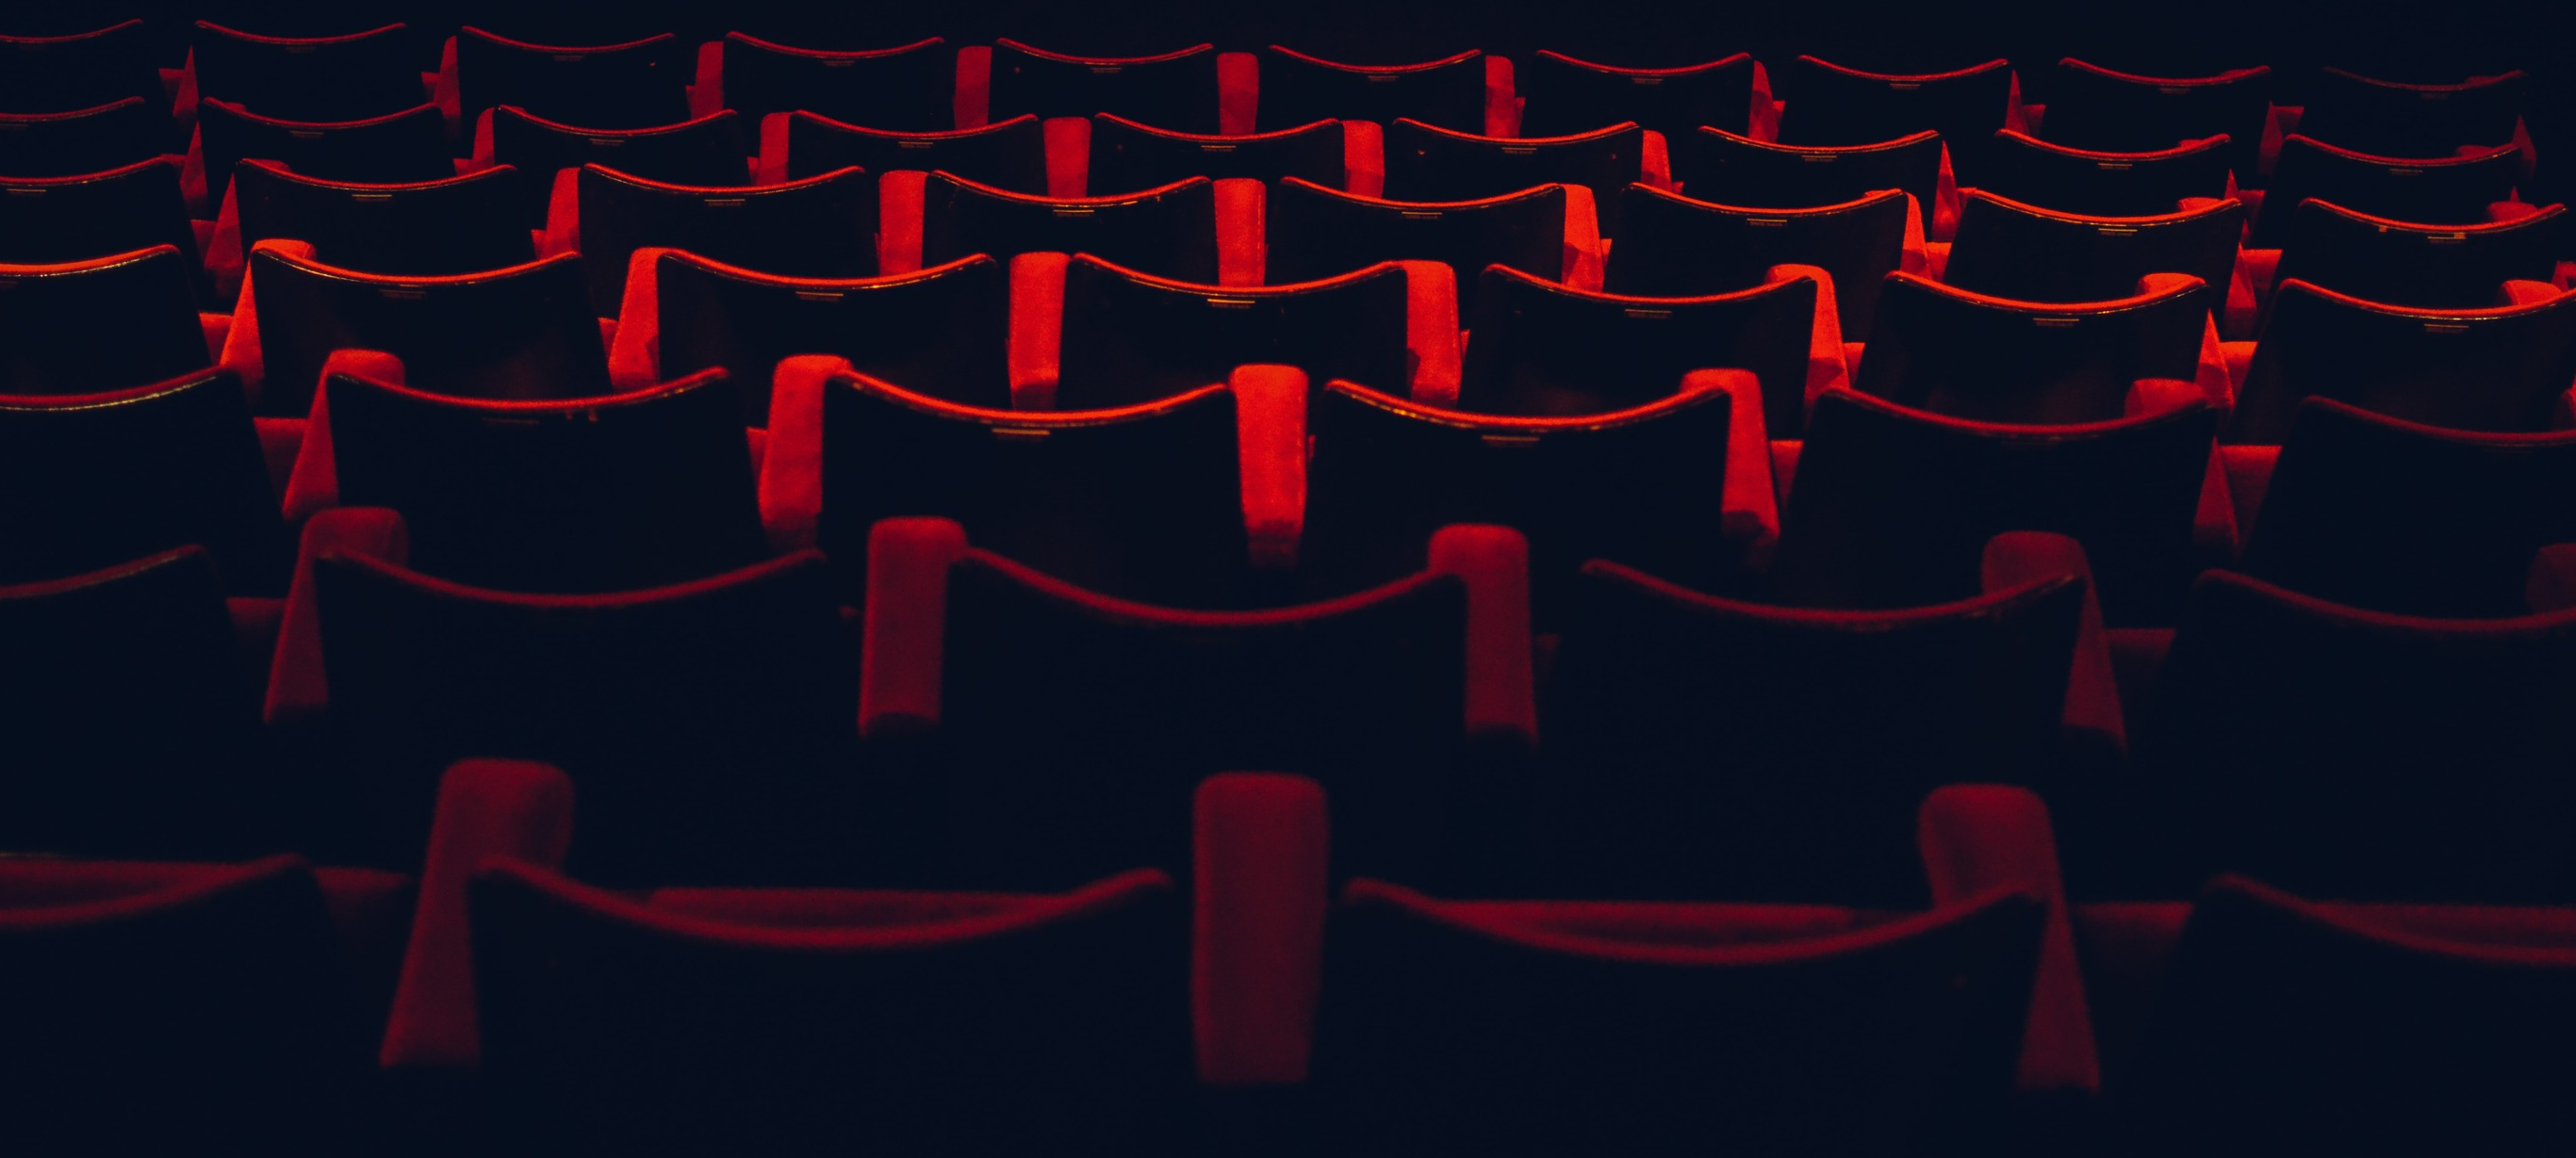

# Is Fandango Movie Rating System Still Biased?
***
## Introduction
### Context Backstory
[Fandango](https://www.fandango.com) is a digital network, serving visitors with movie information and rating, ticketing, trailers and original video, home entertainment and fan merchandise. For movie rating, Fandango uses a 5-star system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

In October 2015, a data journalist Walt Hickey conducted movie rating data analysis (published in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/)) and found a significant discrepancy between the number of stars displayed to users and the actual rating in the HTML of the page, which can suggest that Fandango's rating system was biased and dishonest. According to his analysis, the actual rating was almost always rounded **up** to the nearest half-star, the actual half-star rating – up to the nearest whole star, and on one occasion, a movie rating was even rounded up by an entire star, from 4 to 5.

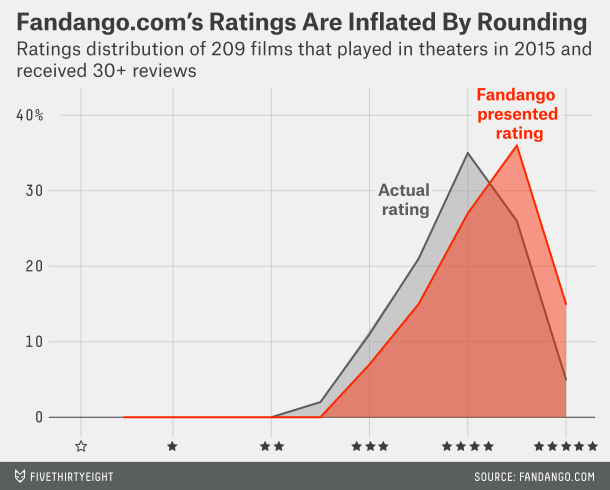

This graph, taken from Hickey's article, shows actual and displayed movie ratings, with relative frequency in percentage for each unique rating. Both distributions are strongly left skewed, 
suggesting that movie ratings on Fandango are generally high to very high. Moreover, the displayed rating distribution is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

The official reply from Fandango was that the biased rounding was not intentional but caused by a bug in their system, which was supposed to be fixed as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in their pages' HTML.

### Project Goal
The goal of this project  is to analyze more recent movie ratings data and determine whether there has been any change in Fandango's rating system after Hickey's analysis.
### Summary of Results
Having explored the data available, we found out that Fandango's rating system has been insignificantly improved in 2016, but remained rather biased anyway with respect to the other aggregators. The most reliable aggregator for checking a movie rating is Metacritic (expert scores).
## Data Understanding
Let's start from comparing the system's characteristics before and after the analysis. Fortunately, we have the necessary data for both periods of time:
- The data from Hickey's analysis is publicly available [on GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango).
- The data after the analysis, represented by the ratings for movies released in 2016 and 2017, was collected by one of the [Dataquest](https://www.dataquest.io) team members and made publicly available [on GitHub](https://github.com/mircealex/Movie_ratings_2016_17).

First, we'll import all the necessary libraries, then read the corresponding datasets into pandas and conduct some initial analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

fandango_before = pd.read_csv('fandango_score_comparison.csv')
fandango_after = pd.read_csv('movie_ratings_16_17.csv')

fandango_before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [2]:
fandango_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [3]:
fandango_before.columns

Index(['FILM', 'RottenTomatoes', 'RottenTomatoes_User', 'Metacritic',
       'Metacritic_User', 'IMDB', 'Fandango_Stars', 'Fandango_Ratingvalue',
       'RT_norm', 'RT_user_norm', 'Metacritic_norm', 'Metacritic_user_nom',
       'IMDB_norm', 'RT_norm_round', 'RT_user_norm_round',
       'Metacritic_norm_round', 'Metacritic_user_norm_round',
       'IMDB_norm_round', 'Metacritic_user_vote_count', 'IMDB_user_vote_count',
       'Fandango_votes', 'Fandango_Difference'],
      dtype='object')

We see that the `fandango_before` dataframe contains 146 entries (films) and 22 columns, representing ratings from different sources for each film (Rotten Tomatoes, Metacritic, IMDB, Fandango) and user vote counts. There are no missing values in the dataframe.

Now, we'll take a look at the `fandango_after` dataframe:

In [4]:
fandango_after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


In [5]:
fandango_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


In [6]:
fandango_after.columns

Index(['movie', 'year', 'metascore', 'imdb', 'tmeter', 'audience', 'fandango',
       'n_metascore', 'n_imdb', 'n_tmeter', 'n_audience', 'nr_metascore',
       'nr_imdb', 'nr_tmeter', 'nr_audience'],
      dtype='object')

The `fandango_after` dataframe has 214 entries (films) and 15 columns, representing the release year of the movie, critic and/or user ratings from the Rotten Tomatoes, Metacritic, IMDB, and Fandango. Also in this dataframe there are no missing values.

Our next step in the data understanding process will be to **define the population of interest** for our project's goal.

First, we want to figure out whether the two samples are representative for the population we're trying to describe. For this purpose, we have consulted the corresponding `README.md` files of both repositories and also Hickey's article. 

We found out that for each dataset **different sampling criteria were used**. 

The dataset *before* the analysis contains only the movies that at the time of sampling (Aug. 24, 2015) have had:
- a Rotten Tomatoes rating, an RT User rating, a Metacritic score, a Metacritic User score, and an IMDb score,
- at least 30 fan reviews on Fandango,
- tickets on sale in 2015.

The dataset *after* the analysis contains only the movies that are:
- the most popular ones, with a significant number of votes (but it's not specified in the file what "significant" means in this context),
- released in 2016 and 2017.

This means that the **sampling process in both cases was more selective rather than random**, and not all the movies had an equal chance to be included in the two samples. Hence, the resulting samples are very unlikely to be representative of the entire population of interest. 

At this point, we can decide or to collect new data, or to tweak the goal of our analysis so that to change the population of interest and make the available samples representative. The second approach looks much faster and, in general, more realistic, so let's hold to it.

## Project Goal Tweaking 
Our initial goal, as stated in the introduction, was to analyze more recent movie ratings data and determine whether there has been any change in Fandango's rating system after Hickey's analysis. Introducing changes to this statement, we have to keep in mind that the modified goal has still to be its fairly good proxy.

We see that in both samples the selected movies are somehow the popular ones (even though the quantitive definition of popularity for them differs), and have ratings from the same review sources, including Rotten Tomatoes, Metacritic, IMDB, and Fandango (for now, we'll be interested only in Fandango's ratings). The dataset before the analysis (the `fandango_before` dataframe) is related to 2015, while the one after the analysis (`fandango_after`) – to 2016 and 2017. We can decide to exclude the data for 2017 from the second dataset and compare only the year before the analysis (2015) and the year after (2016). In this way, our new project goal is **to analyze popular movie ratings for 2015 and determine whether Fandango changed their rating system for popular movies in 2016**. 
## Sample Isolating
With our project goal updated, we now have 2 representative samples to be described and compared: `fandango_before` and `fandango_after`. They still need some QC and cleaning, however: defining more specifically the term "popular" and removing the movies released in other years than 2015 and 2016.

As for the popularity measurement, the `fandango_before` dataframe is defined more precisely, containing the films with at least 30 fan reviews on Fandango. In case of `fandango_after`, the measurement is not that clear, since we don't know what exactly "significant number of votes" means.
Hence, for considering a movie popular, let's stick to the criterion of **at least 30 fan reviews**.

Let's double-check that the `fandango_before` dataframe contains only the movies with at least 30 fan reviews:

In [7]:
len(fandango_before[fandango_before['Fandango_votes']>=30])==len(fandango_before)

True

In the `fandango_after` dataframe, however, we don't have any information about the fan rating number for each movie. As a workaround for checking if the dataframe is still representative enough for our purposes, we can sample it and check manually the number of fan ratings for each sample point (movie) on Fandango's website. If 80-90% of the sample points satisfy our criterion of having at least 30 fan reviews, we can conclude that the dataframe is representative.

In [8]:
# Sampling randomly 10 films from `fandango_after`
fandango_after[['movie', 'year', 'fandango']].sample(10, random_state=1000)

,movie,year,fandango
16,Bad Santa 2,2016,3.5
59,Genius,2016,3.5
74,I.T.,2016,3.5
64,Gold,2016,3.5
116,Moonlight,2016,4.0
57,Florence Foster Jenkins,2016,4.0
166,The Bye Bye Man,2017,3.0
126,Office Christmas Party,2016,3.5
175,The Forest,2016,3.0
39,"Crouching Tiger, Hidden Dragon: Sword of Destiny",2016,4.0


Looking up these movies on Fandango's website, at the time of this writing (February 2021) we have the following pretty-printed results:

In [9]:
# Pretty-printing the 10 sampled films together with the corresponding numbers of fan reviews
print(tabulate(list(zip(
                        fandango_after[['movie', 'year', 'fandango']]            # 1st column: 10 film titles to list
                        .sample(10, random_state=1000)['movie'].tolist(),
                        ['10,000+', '2,500+', '250+', '5,000+', '25,000+', '10,000+', '5,000+', '10,000+',  
                          '10,000+', '10,000+']        # 2nd column: manually checked numbers of fan ratings on Fandango.com
                        )),
               headers=['movie', 'fan reviews'],
               tablefmt='orgtbl'))

| movie                                            | fan reviews   |
|--------------------------------------------------+---------------|
| Bad Santa 2                                      | 10,000+       |
| Genius                                           | 2,500+        |
| I.T.                                             | 250+          |
| Gold                                             | 5,000+        |
| Moonlight                                        | 25,000+       |
| Florence Foster Jenkins                          | 10,000+       |
| The Bye Bye Man                                  | 5,000+        |
| Office Christmas Party                           | 10,000+       |
| The Forest                                       | 10,000+       |
| Crouching Tiger, Hidden Dragon: Sword of Destiny | 10,000+       |


In our sample of 10 points, each movie has at least 30 (actually, much more) fan reviews, which reflects the overall tendency in the `fandango_after` dataframe and makes it representative for our purposes.

Next, let's check what years of release are represented in both dataframes. In `fandango_before`, we don't have a corresponding column, but we can extract the year from the `FILM` column:

In [10]:
fandango_before['FILM'].head()

0    Avengers: Age of Ultron (2015)
1                 Cinderella (2015)
2                    Ant-Man (2015)
3            Do You Believe? (2015)
4     Hot Tub Time Machine 2 (2015)
Name: FILM, dtype: object

In [11]:
# Extracting the year from the `FILM` column
fandango_before['Year'] = fandango_before['FILM'].str[-6:-1].str.replace('(', '')

# Checking the years of release represented in `fandango_before`, in %
round(fandango_before['Year'].value_counts(normalize=True)*100)

2015    88.0
2014    12.0
Name: Year, dtype: float64

12% of movies in the `fandango_before` dataframe were released in 2014. According to our updated goal, we're interested only in comparing movies of 2015 vs. 2016, so here we'll leave only those released in 2015:

In [12]:
# Leaving only the movies released in 2015
fandango_before = fandango_before[fandango_before['Year']=='2015']
fandango_before['Year'].unique()

array(['2015'], dtype=object)

In the `fandango_after` dataframe, there is already a column called `year`:

In [13]:
# Checking the years of release represented in `fandango_after`, in %
round(fandango_after['year'].value_counts(normalize=True)*100)

2016    89.0
2017    11.0
Name: year, dtype: float64

11% of movies in the `fandango_after` dataframe were released in 2017. For our purposes, we'll leave only those released in 2016:

In [14]:
# Leaving only the movies released in 2016
fandango_after = fandango_after[fandango_after['year']==2016]
fandango_after['year'].unique()

array([2016], dtype=int64)

Let's check how many movies remained in each dataset:

In [15]:
print('Number of movies in `fandango_before`:', len(fandango_before),
      '\nNumber of movies in `fandango_after`:', len(fandango_after))

Number of movies in `fandango_before`: 129 
Number of movies in `fandango_after`: 191


Now, we have 2 cleaned representative datasets, ready for further analysis.
## Comparing Distribution Shapes for 2015 and 2016
In the introduction, we saw a comparison between the distribution shapes of Fandango's actual vs. displayed movie ratings from Hickey's analysis. Let's now compare the shapes of the movie rating distributions for 2015 and 2016. 

(As a side note, for styling purposes, throughout this project we're going to use FiveThirtyEight style for plotting, having been inspired by [this article](https://www.dataquest.io/blog/making-538-plots/).)

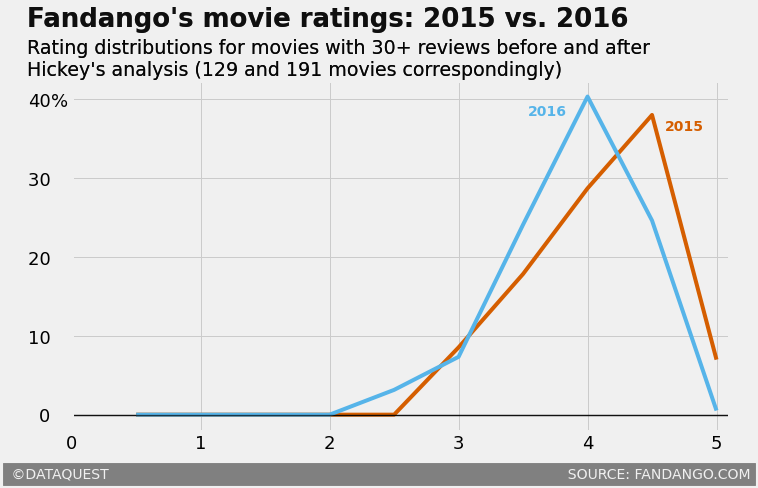

In [16]:
# Selecting the "FiveThirtyEight" style for plotting
plt.style.use('fivethirtyeight')

# Creating a list of colorblind-friendly colors
colors = [[213/255,94/255,0],        # vermillion
          [86/255,180/255,233/255],  # sky blue
          [230/255,159/255,0],       # orange
          [0,158/255,115/255],       # bluish green
          [204/255,121/255,167/255], # reddish purple
          [0,114/255,178/255]]       # blue

# Defining a function for improving plot aesthetics and reproducing the FiveThirtyEight style
def add_plot_aesthetics(ax, y_ticks, y_ticklabels, y_line,
                        x_start, x_end,
                        x_title, y_title, title,
                        x_subtitle, y_subtitle, subtitle,
                        x_signbar, y_signbar, signbar_text):
    ax.tick_params(axis='both', labelsize=18)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    ax.axhline(y_line, color='black', linewidth=1.3, alpha=0.7)
    ax.set_xlim(x_start, x_end)
    ax.text(x_title, y_title, s=title,
            fontsize=26, weight='bold', alpha=0.75)
    ax.text(x_subtitle, y_subtitle, s=subtitle,
            fontsize=19, alpha=0.85)
    ax.text(x_signbar, y_signbar, s=signbar_text,
            fontsize=14, color='#f0f0f0', backgroundcolor='grey')
    return ''

#  Creating plots for comparing the movie rating distribution shapes for 2015 and 2016
fig, ax = plt.subplots(figsize=(10.5,6))

# Creating lists of dataframes, columns with Fandango's ratings, and years
dfs = [fandango_before, fandango_after]
columns = ['Fandango_Stars', 'fandango']
labels = ['2015', '2016']

for i in range(len(dfs)):
    
    # Creating a relative frequency table (in %) for given column sorted by rating
    ratings = dfs[i][columns[i]].value_counts(normalize=True).sort_index()*100
    
    # Adding missing unique ratings from 0.5 to 5 (in our case – low ratings) and assigning 0 to their frequencies
    ratings_arranged = pd.Series(ratings, index=np.arange(0.5,5.1,0.5).tolist()).fillna(0)
    
    # Plotting the resulting Series
    ax = ratings_arranged.plot(label=labels[i], c=colors[i])
    
    # Adding plot aesthetics according to the FiveThirtyEight style
    add_plot_aesthetics(ax=ax, y_ticks=(0, 10, 20, 30, 40),
                        y_ticklabels=('0   ', '10   ', '20   ', '30   ', '40%'), y_line=0,
                        x_start=0, x_end=5.1,
                        x_title=-0.35, y_title=49.2,
                        title='Fandango\'s movie ratings: 2015 vs. 2016',
                        x_subtitle=-0.35, y_subtitle=43,
                        subtitle='Rating distributions for movies with 30+ reviews before and after\
                 \nHickey\'s analysis (129 and 191 movies correspondingly)',
                        x_signbar=-0.5, y_signbar=-8,
                        signbar_text=' ©DATAQUEST                                                                                                      SOURCE: FANDANGO.COM')
   
    # Adding annotations to the plots
    ax.text(x=4.6, y=36,
            s='2015',
            color=colors[0],
            weight='bold',
            backgroundcolor='#f0f0f0')
    ax.text(x=3.54, y=38,
            s='2016',
            color=colors[1],
            weight='bold',
            backgroundcolor='#f0f0f0')
plt.show()

We can notice the following changes:
- Both distributions are strongly left skewed, but the one for 2016 is a bit less skewed. 
- The mode of the distribution for 2015 is 4.5, while the one for 2016 is 4.
- In 2015 the minimum Fandango's movie rating was 3, while in 2016 it was reduced to 2.5.

These observations suggest that after the article Fandango's rating system was really changed, and the movies in 2016 were rated slightly lower, towards more realistic values, compared to 2015.
## Comparing Relative Frequencies
Let's now  analyze more granular information about our samples, using the frequency distribution tables for Fandango's movie ratings. Since the samples have different number of movies, it makes more sense to compare the two tables using relative frequencies rather than absolute ones. We'll use relative frequencies in percentages:

In [17]:
# Pretty-printing frequency tables in % for each dataset
print('\nFrequency table for `fandango_before`:\n')
print(tabulate(round(fandango_before['Fandango_Stars'].value_counts(normalize=True)\
                                                      .sort_index(ascending=False)*100).to_frame(),
               headers=['Rating', 'Frequency'],
               tablefmt='orgtbl'), 2*'\n')
print('Frequency table for `fandango_after`:\n')
print(tabulate(round(fandango_after['fandango'].value_counts(normalize=True)\
                                               .sort_index(ascending=False)*100).to_frame(),
               headers=['Rating', 'Frequency'],
               tablefmt='orgtbl'))


Frequency table for `fandango_before`:

|   Rating |   Frequency |
|----------+-------------|
|      5   |           7 |
|      4.5 |          38 |
|      4   |          29 |
|      3.5 |          18 |
|      3   |           9 | 


Frequency table for `fandango_after`:

|   Rating |   Frequency |
|----------+-------------|
|      5   |           1 |
|      4.5 |          25 |
|      4   |          40 |
|      3.5 |          24 |
|      3   |           7 |
|      2.5 |           3 |


We can make the following observations for the movie ratings after Hickey's article:
- There are less movies rated 5 and 4.5 (-6% and -13% correspondingly).
- Instead, the number of movies rated 4 and 3.5 increased (+11% and +6%).
- The number of movies rated 3 slightly decreased (-2%).
- In 2016, we have even 3% of movies rated 2.5.
- Both before and after the analysis, the predominant majority of movies are rated from 3.5 to 4.5.

Hence, the difference *before-after* is still rather evident, but the direction of the difference is not that clear anymore.

## Determining the Direction of the Change
To better understand the direction of the difference, we'll calculate, plot and compare summary statistics (mean, median, and mode) for each distribution of movie ratings:



|      |    Mean |   Median |   Mode |
|------+---------+----------+--------|
| 2015 | 4.08527 |        4 |    4.5 |
| 2016 | 3.88743 |        4 |    4   | 



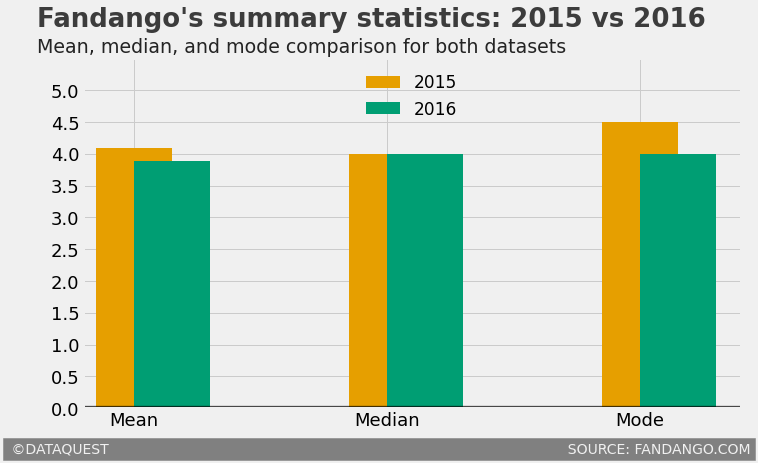

In [18]:
# Creating a list of Fandango's rating columns in both datasets
rating_columns = [fandango_before['Fandango_Stars'],
                  fandango_after['fandango']]

# Creating a list of summary statistics for Fandango's rating columns
list_sum_stat = []
for item in rating_columns:
    lst = [item.mean(),
           item.median(),
           item.mode().loc[0]]
    list_sum_stat.append(lst)
    
# Creating a dataframe from the list of summary statistics
df_sum_stat = pd.DataFrame(list_sum_stat,
                           columns=['Mean', 'Median', 'Mode'],
                           index=['2015', '2016'])

# Pretty-printing the dataframe of summary statistics
print('\n')
print(tabulate(df_sum_stat,
               headers=df_sum_stat.columns,
               tablefmt='orgtbl'), '\n')

# Creating a grouped bar plot for the summary statistics
fig = plt.subplots(figsize = (10.5,6))
ax = df_sum_stat.loc['2015'].plot.bar(color=colors[2],
                                      align='center',
                                      label='2015',
                                      width=0.3)
ax = df_sum_stat.loc['2016'].plot.bar(color=colors[3],
                                      align='edge',
                                      label='2016',
                                      width=0.3,
                                      rot=0)

# Adding plot aesthetics according to the FiveThirtyEight style
add_plot_aesthetics(ax=ax, y_ticks=np.arange(0,5.1,.5),
                    y_ticklabels=np.arange(0,5.1,.5).tolist(), y_line=0.03,
                    x_start=-0.2, x_end=2.4,
                    x_title=-0.383, y_title=6,
                    title='Fandango\'s summary statistics: 2015 vs 2016',
                    x_subtitle=-0.383, y_subtitle=5.6,
                    subtitle='Mean, median, and mode comparison for both datasets',
                    x_signbar=-0.5, y_signbar=-0.7,
                    signbar_text=' ©DATAQUEST                                                                                                      SOURCE: FANDANGO.COM')
                    
# Adding case-specific plot aesthetics
ax.set_ylim(0,5.5)
ax.legend(frameon=0, loc='upper center', fontsize=17)

plt.show()

Here we can observe the following changes in rating summary statistics:
- The mean has decreased by around 5% with respect to the one before the article.
- The median has remained the same.
- The mode has dropped by 0.5 points.

These results confirm once again that **Fandango's rating system has been improved** and become less biased after Hickey's analysis, even though the **difference doesn't look something significant**.

## Comparing Different Movie Rating Aggregators
To grasp the whole picture, we should compare the rating distributions from different movie rating aggregators: Fandango, Rotten Tomatoes, Metacritic, and IMDB. In this way, we'll check two things:
- Is Fandango's rating distribution indeed so much different from those of the other aggregators? For example, is it somehow possible that all the movies released in 2015 (as well as in 2016) were so amazing that both users and experts on all the aggregators estimated them very high?
- If it's not the case (most probably), then what is the most reliable aggregator to check for a movie rating?

For these purposes, we're going to take a look at both datasets separately. In both cases, we'll use the ratings **normalized to a Fandango-style 5-point scale** (since the rating systems are different for the other aggregators) and **rounded to the nearest half-star**.

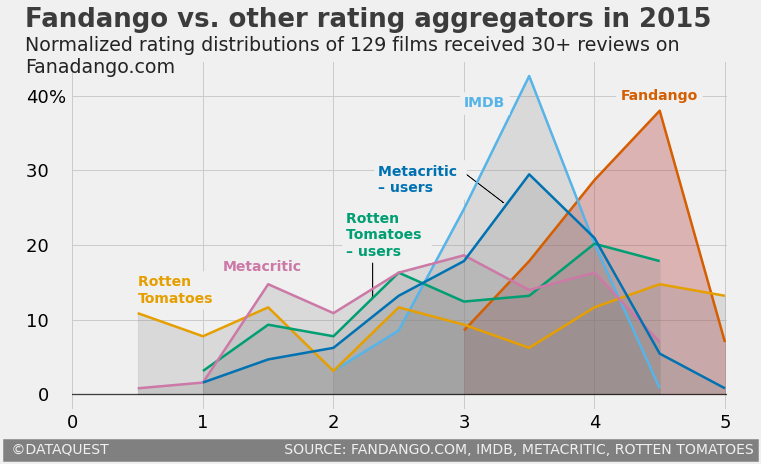

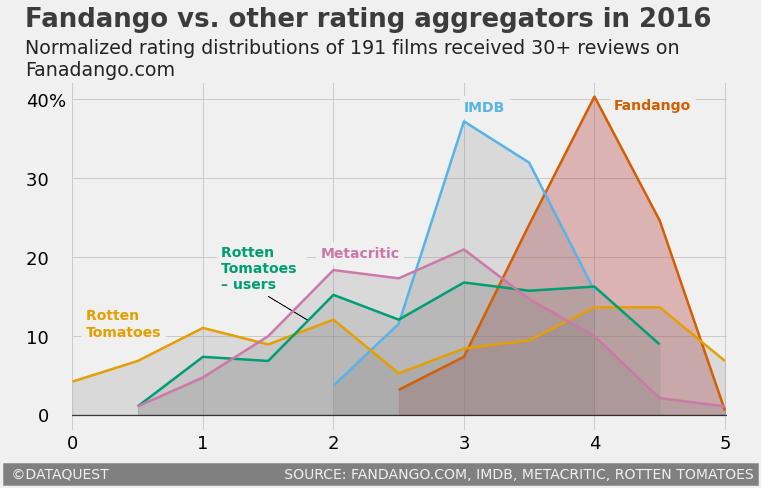

In [19]:
# Defining a function for plotting different aggregator distributions
def plot_aggregator_distributions(df, columns, n_plots, column_fandango,
                                  year, n_films,
                                  x_annotations, y_annotations,
                                  n_arrows, x_arrow, y_arrow, dx_arrow, dy_arrow):
    fig, ax = plt.subplots(figsize=(10.5,6))
    labels = ['Fandango', 'IMDB', 'Rotten \nTomatoes', 'Rotten \nTomatoes \n– users',
             'Metacritic', 'Metacritic \n– users']
    
    for i in range(n_plots):
        
        # Creating a relative frequency table (in %) for given column sorted by rating
        ratings = df[columns[i]].value_counts(normalize=True).sort_index()*100
        
        # Plotting the resulting Series
        ax = ratings.plot(linewidth=2.5, c=colors[i])
        
        # Filling the area under the plots with colors, emphasizing Fandango
        if columns[i]==column_fandango:
            ax.fill_between(ratings.index.tolist(), ratings.tolist(), alpha=0.2, color='red')
        ax.fill_between(ratings.index.tolist(), ratings.tolist(), alpha=0.2, color='grey')
        
        # Adding an annotation to each graph
        ax.text(x=x_annotations[i], y=y_annotations[i],
                s=labels[i], color=colors[i],
                weight='bold', backgroundcolor='#f0f0f0')
    
    # Adding plot aesthetics according to the FiveThirtyEight style
    add_plot_aesthetics(ax, y_ticks=(0, 10, 20, 30, 40),
                        y_ticklabels=('0   ', '10   ', '20   ', '30   ', '40%'), y_line=0,
                        x_start=-0.02, x_end=5.02,
                        x_title=-0.36, y_title=49.2,
                        title=f'Fandango vs. other rating aggregators in {year}',
                        x_subtitle=-0.36, y_subtitle=43,
                        subtitle=f'Normalized rating distributions of {n_films} films received 30+ reviews on \nFanadango.com',
                        x_signbar=-0.5, y_signbar=-8,
                        signbar_text=' ©DATAQUEST\
                                       SOURCE: FANDANGO.COM, IMDB, METACRITIC, ROTTEN TOMATOES')
   
    # Adding arrows
    for j in range(n_arrows):
        ax.arrow(x=x_arrow[j], y=y_arrow[j],
                 dx=dx_arrow[j], dy=dy_arrow[j],
                 width=0.005, fc='k', ec='k')
        
    plt.show()
    return ''

# Plotting different aggregator distributions for 2015
plot_aggregator_distributions(df=fandango_before,
                              columns=['Fandango_Stars', 'IMDB_norm_round', 'RT_norm_round',
                                       'RT_user_norm_round', 'Metacritic_norm_round',
                                       'Metacritic_user_norm_round'],
                              n_plots=6, column_fandango='Fandango_Stars',
                              year=2015, n_films = 129,
                              x_annotations=[4.2, 3, 0.5, 2.1, 1.15, 2.34],
                              y_annotations=[39.5, 38.5, 12.3, 18.6, 16.5, 27.15],
                              n_arrows=2, x_arrow=[3,2.3], y_arrow=[29.7,18],
                              dx_arrow=[0.3,0], dy_arrow=[-4,-5])

# Plotting different aggregator distributions for 2016
plot_aggregator_distributions(df=fandango_after,
                              columns=['fandango', 'nr_imdb', 'nr_tmeter', 'nr_audience',
                                       'nr_metascore'],
                              n_plots=5, column_fandango='fandango',
                              year=2016, n_films = 191,
                              x_annotations=[4.15, 3, 0.1, 1.14, 1.9],
                              y_annotations=[38.7, 38.5, 10, 16, 20],
                              n_arrows=1, x_arrow=[1.5], y_arrow=[15],
                              dx_arrow=[0.3], dy_arrow=[-3])
plt.show()

Answering our two questions above, we can definitely say that **Fandango's rating distribution is significantly different from those of the other aggregators both before and after the article**. It means that already the actual ratings in their pages' HTML were hugely inflated, probably because of some specific approach for gathering ratings, or an intentional filtering, but doesn't look to be just a "system bug". After Hickey's analysis, Fandango's rating distribution has slightly shifted to the left, becoming less left skewed. However, with respect to the other aggregators, it still looks totally unrealistic and, hence, unreliable.

Instead, as for *the most reliable aggregator* for checking a movie rating, it results to be **Metacritic (expert scores)**, since its rating distribution shape resembles a normal distribution most of all.

Finally, let's take a look at summary statistics for all the aggregators:



|    | Aggregator              |   Mean |   Median |   Mode |
|----+-------------------------+--------+----------+--------|
|  0 | Fandango                |   4.09 |      4   |    4.5 |
|  1 | IMDB                    |   3.35 |      3.5 |    3.5 |
|  2 | Rotten Tomatoes         |   2.94 |      3   |    4.5 |
|  3 | Rotten Tomatoes – users |   3.17 |      3.5 |    4   |
|  4 | Metacritic              |   2.88 |      3   |    3   |
|  5 | Metacritic – users      |   3.22 |      3.5 |    3.5 | 



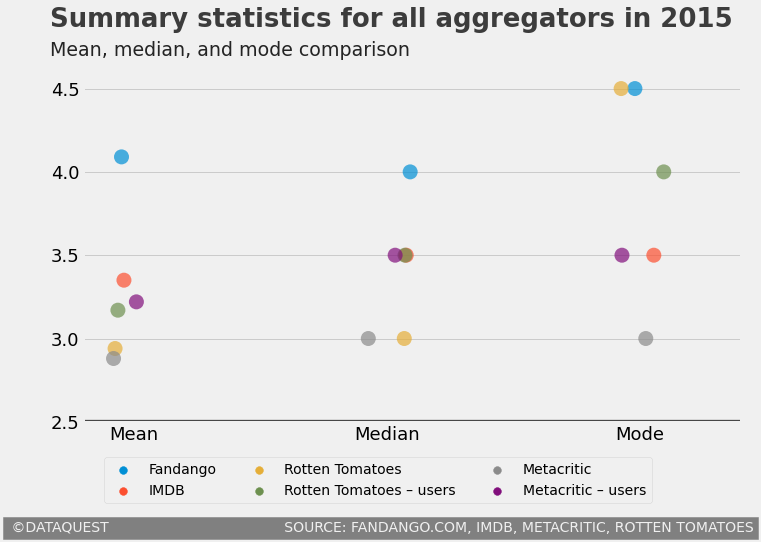



|    | Aggregator              |   Mean |   Median |   Mode |
|----+-------------------------+--------+----------+--------|
|  0 | Fandango                |   3.89 |      4   |      4 |
|  1 | IMDB                    |   3.22 |      3   |      3 |
|  2 | Rotten Tomatoes         |   2.73 |      3   |      4 |
|  3 | Rotten Tomatoes – users |   2.89 |      3   |      3 |
|  4 | Metacritic              |   2.69 |      2.5 |      3 | 



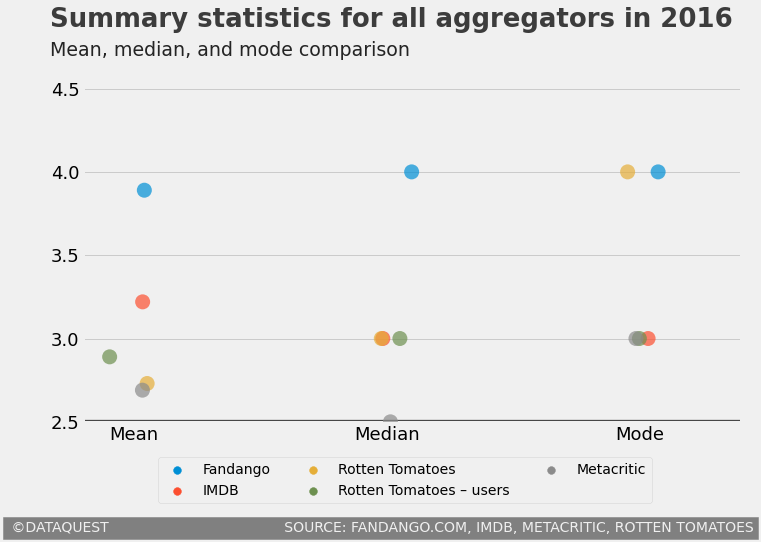

In [20]:
# Defining a function for plotting different aggregator summary statistics
def plot_aggregator_stats(df, columns, labels, year):
    
    # Creating a list of summary statistics for all aggregators' rating columns
    list_sum_stat = []
    rating_columns = []
    for i in range(len(columns)):
        rating_columns.append(df[columns[i]])
        lst = [labels[i],
               round(rating_columns[i].mean(),2),
               rating_columns[i].median(),
               rating_columns[i].mode().loc[0]]
        list_sum_stat.append(lst)
        
    # Creating a dataframe from the list of summary statistics
    df_sum_stat = pd.DataFrame(list_sum_stat, columns=['Aggregator', 'Mean', 'Median', 'Mode'])
    
    # Pretty-printing the dataframe of summary statistics
    print('\n')
    print(tabulate(df_sum_stat,
                   headers=df_sum_stat.columns,
                   tablefmt='orgtbl'), '\n')
    
    # Melting the dataframe for further plotting
    melted = pd.melt(df_sum_stat, id_vars=['Aggregator'], value_vars=['Mean', 'Median', 'Mode'])

    
    # Creating a strip plot for the summary statistics
    fig,ax = plt.subplots(figsize=(10.5,6))
    ax = sns.stripplot(x = 'variable', y = 'value', hue='Aggregator',
                       s=15, alpha=0.7, data = melted)
    
    # Adding plot aesthetics according to the FiveThirtyEight style
    add_plot_aesthetics(ax, y_ticks=np.arange(0,5.1,.5), y_ticklabels=np.arange(0,5.1,.5).tolist(),
                        y_line=2.51,
                        x_start=-0.2, x_end=2.4,
                        x_title=-0.332, y_title=4.87,
                        title=f'Summary statistics for all aggregators in {year}',
                        x_subtitle=-0.332, y_subtitle=4.7,
                        subtitle='Mean, median, and mode comparison',
                        x_signbar=-0.5, y_signbar=1.84,
                        signbar_text=' ©DATAQUEST\
                                       SOURCE: FANDANGO.COM, IMDB, METACRITIC, ROTTEN TOMATOES')
   
    # Adding case-specific plot aesthetics
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.set_ylim(2.5,4.6)
    ax.legend(fontsize=14, bbox_to_anchor=(0.875,-0.08), ncol=3)
    
    plt.show()
    return ''
    
# Plotting different aggregator summary statistics for 2015
plot_aggregator_stats(df=fandango_before,
                      columns=['Fandango_Stars', 'IMDB_norm_round', 'RT_norm_round',
                               'RT_user_norm_round', 'Metacritic_norm_round',
                               'Metacritic_user_norm_round'],
                      labels=['Fandango', 'IMDB', 'Rotten Tomatoes',
                              'Rotten Tomatoes – users', 'Metacritic', 'Metacritic – users'],
                      year=2015)

# Plotting different aggregator summary statistics for 2016
plot_aggregator_stats(df=fandango_after,
                      columns=['fandango', 'nr_imdb', 'nr_tmeter', 'nr_audience',
                               'nr_metascore'],
                      labels=['Fandango', 'IMDB', 'Rotten Tomatoes',
                              'Rotten Tomatoes – users', 'Metacritic'],
                      year=2016)
plt.show()

Not surprisingly, we see that **all the summary statistics are evidently higher for Fandango** both in 2015 and 2016, with the only exception for Rotten Tomatoes that reached Fandango  with its mode value.
## Conclusion
In this project, we have analyzed Fandango’s and other aggregators’ ratings for popular movies with at least 30 fan reviews on www.fandango.com before Hickey’s article in 2015, to determine whether Fandango was still inflating ratings the year after. Here are our main insights:
- Already the actual ratings in Fandango’s HTML were hugely inflated, presumably because of some specific approach for gathering ratings, or an intentional filtering. Given that Fandango also sells tickets, it doesn't look to be just a "system bug".
- The shapes of Fandango’s movie rating distributions for both 2015 and 2016 are strongly left skewed, but the one for 2016 is a bit less skewed.
- The summary statistics: the mean and the mode have decreased insignificantly, while the median remained the same.
- In 2016, there were less movies with the highest Fandango’s ratings 5 and 4.5, and appeared very few movies with the rating 2.5, while in 2015, the minimum was 3. In both cases, the predominant majority of movies are rated from 3.5 to 4.5.
- From a wider prospective, even if in 2016 Fandango's rating distribution has slightly shifted to the left, towards more realistic values, it still looks totally unrealistic with respect to the other aggregators. In addition, all the summary statistics are evidently higher for Fandango both in 2015 and 2016.
- The most reliable aggregator for checking a movie rating is Metacritic (expert scores), because of its almost normal distribution shape.
- **Main conclusion**: Fandango's rating system has been insignificantly improved in 2016, but remained rather biased anyway.